<a href="https://colab.research.google.com/github/dcard0/ctf2024/blob/main/GAN/Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks (GAN)

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp; Dennis G. Wilson

In [1]:
%matplotlib inline
import itertools
import math
import time
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable
import numpy as np

### The goal of GANs

<b>Generative Adversarial Networks (GAN)</b> are a framework for generating new data which follows an existing distribution. This is often used with images is to generate images which look real, but which don't exist in the training set. The example we'll use today is the MNIST dataset, so we will generate new images which look like handwritten digits but which are created by a neural network.

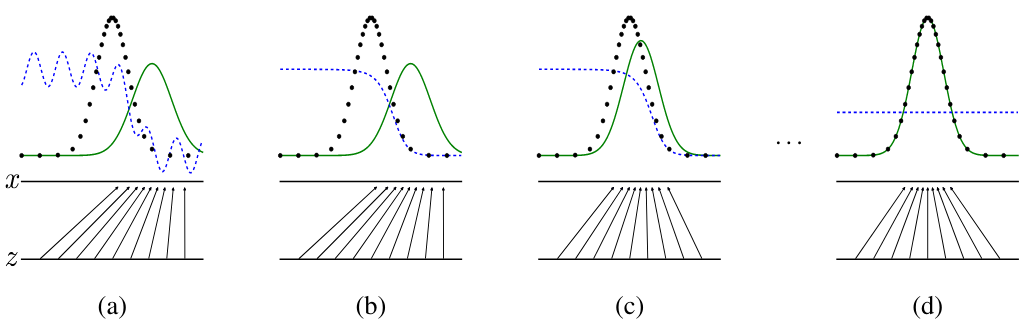

Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014. [pdf](https://arxiv.org/pdf/1406.2661.pdf)

In this framework, two assumptions have to be made:
+ All the data from the training dataset is assumed to follow the same probability distribution noted $p_{data}$. In other words, if the MNIST database is considered, all the 28x28 matrices which represent hand-written numbers are assumed to follow the same probability distribution.

+ The database is assumed large enough that the probability distribution obtained represent well and only those data. In other words, if new sample can be generated from this distribution, they should look like the other elements of the database. In the case of the MNIST database, if new 28x28 matrices may be generated from the distribution $p_{data}$, then they should still represent hand-written numbers.

## Example: MNIST

We'll use the MNIST dataset for the exercise today. We'll download this dataset and make batching data loaders.

In [2]:
# set batch_size
batch_size = 128

# the data, shuffled and split between train and test sets
# we normalize data to have values between -1 and 1
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]) ])

train_dataset = torchvision.datasets.MNIST(root='data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_iterator = iter(train_loader)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:11<00:00, 897kB/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.67MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



As a reminder, let's look at some example digits from the MNIST set.

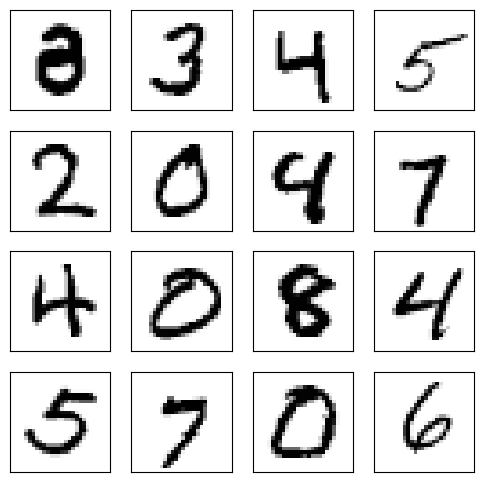

In [3]:
num_test_samples = 16 # number of digits to plot

# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# load a batch of training data
images, labels = next(train_iterator)

# show a subpart of it
for k in range(num_test_samples):
    i = k//4
    j = k%4
    ax[i,j].cla()
    ax[i,j].imshow(images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
    display.clear_output(wait=True)

The task for today is to learn to generate new images which look like these.

## The Generator
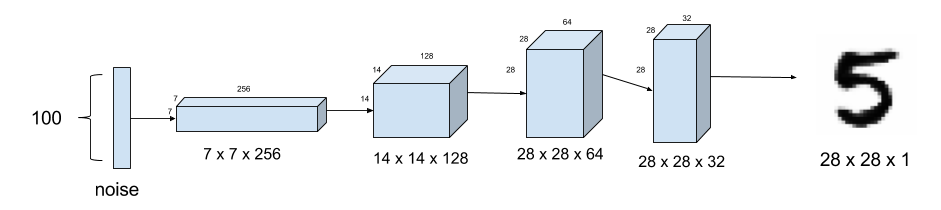

One network - called the <b>Generator</b>- is built and is meant to transform vectors following a random probability distribution $p_z$ - called noise probability distribution - in vectors following natural data distribution $p_{data}$.

To follow the MNIST example, the generator will take as input vectors of real numbers following a gaussian distribution, $p_z$ and should output a 28x28 matrix whose values follow the data probability distribution followed by MNIST images, $p_{data}$. Hence, that network role would be to transform a gaussian distribution into a probability distribution represented by the data.

## The Discriminator
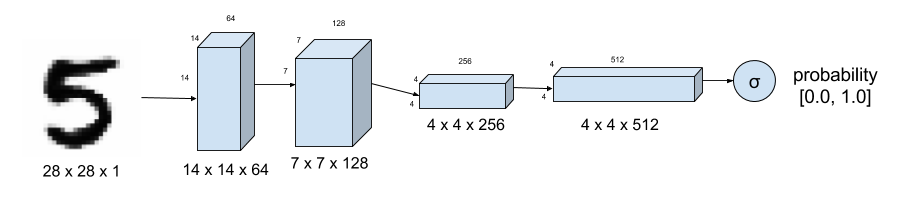

To train the generator, we use a second network called the **Discriminator**. The role of this network is to learn the data distribution $p_{data}$ in order to classify if a sample comes from this distribution or not.

The <b>Discriminator</b>'s goal is to differentiate between samples following the real data probability distribution and samples generated by the generator. It takes as an input either a real sample or a sample output from the generator and is trained to return the likelihood of the image being real. In the maximum, the discriminator is expected to return 1 when it is given an image from the training dataset and to return 0 when it is given an image generated by the generator.

The **adversarial** aspect of the networks comes from the training methods. The generator is trained to fool the discriminator : ie to make it return 1 for generated samples. The networks play a 2-player minimax game. At the equilibrium, the discriminator should always return 0.5 : it cannot make the difference between real and fake samples anymore, hence the fake samples follow the same probability distribution than real ones. The generator is trained towards this result and ends up producing realistic results.

To get a better understanding, let us call G the generator, D the discriminator, $z$ a variable following the noise probability distribution $p_z$ and $x$ a variable following the data probability distribution $p_{data}$. Let us call as well $p_g$ the probability distribution followed by G’s outputs : $G(z)$. Then the generator's goal is to fool the discriminator returning real-like samples which means equalizing $p_g \approx p_{data}$.

The discriminator is trained to return $1$ for real data : $D(x) = 1$ and $0$ for fake data $D(G(z)) = 0$ while the generator is trained to make the discriminator returning $1$ as well for fake data. Hence, D and G play the two-player minimax game with value function $V(G, D)$:

$$\min_{G} \max_{D} V(D,G)  = \mathbb{E}_{x\sim p_{data}}[log D(x)] + \mathbb{E}_{z\sim p_{z}}[log(1 - D(G(z)))]$$

The implementation of this game results in the following algorithm, described in the original GAN paper:
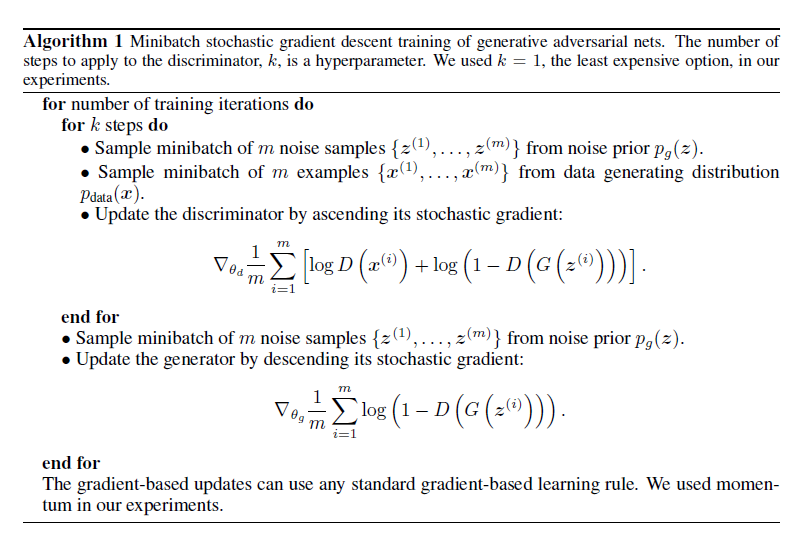

# GANs in Practice


### Build the Discriminator

We now build both the networks, starting with the easier one: the discriminator.

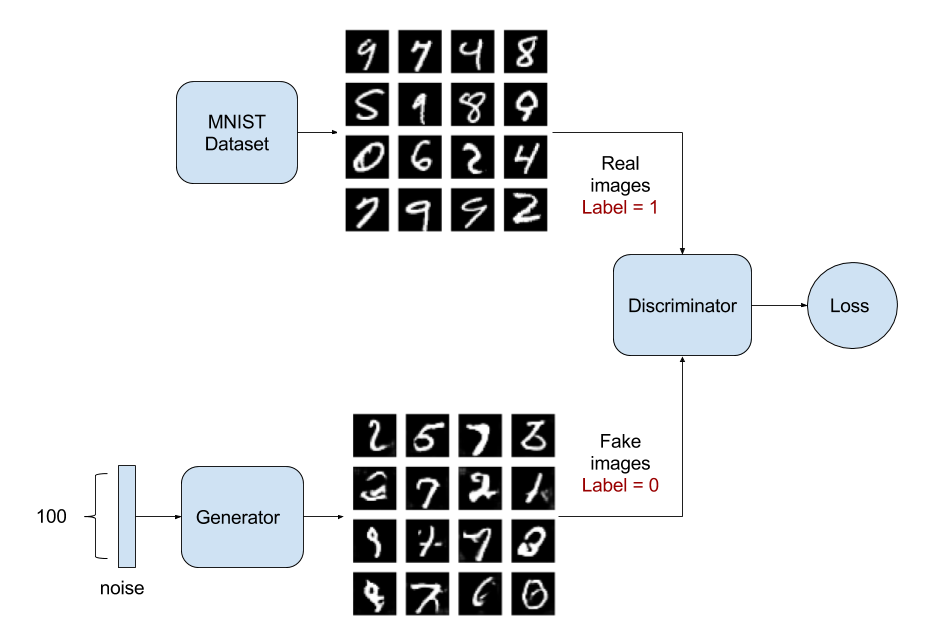

We'll start with a simple discriminator model of feed-forward ReLU fully connected layers. The role of the discriminator is to distinguish real or fake samples, so the final neuron should give a probability that an image is real; we will use a sigmoid activation for the final neuron.

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out

Let's test a random discriminator on some MNIST data.

In [5]:
# load a batch of training data
images, labels = next(train_iterator)
discriminator = Discriminator()

outs = discriminator(images)
print(outs.data.cpu().numpy()[:10])

[[0.5002383 ]
 [0.50090754]
 [0.5003721 ]
 [0.4946434 ]
 [0.49580604]
 [0.49846545]
 [0.4999777 ]
 [0.49294552]
 [0.5040853 ]
 [0.49736005]]


The random discriminator doesn't have very relevant guesses yet - mostly around 50%. We need to train it, but we only have **positive** examples (ie, the data). In order to train the discriminator, we need **negative** examples, in other words, fake images. We will generate those with the generator.

<div class="alert alert-success">
    <h2>Exercise 1</h2>

Write the generator code. It should take a vector of size 100 as input and output a flattened vector of 784 pixels. You can use feed-forward layers, similar to the Discriminator. What activation function should the final layer have? Consider that it is supposed to output black and white pixel values.
    
</div>

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),  # Input: vector of size 100
            nn.ReLU(inplace=True),  # Activation
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),  # Output: vector of size 784
            nn.Tanh()  # Scale output to [-1, 1]
        )

    def forward(self, x):
        out = self.model(x)
        return out


Once the class are written, we instantiate the networks.

In [9]:
discriminator = Discriminator()
generator = Generator()

Let's load some example data to go through the training steps. First we'll load the images and generate the labels. Note that the label for training the discriminator is not the number drawn in the image; it is simply 1 for all images from the real data set and 0 for all images from the generated set.

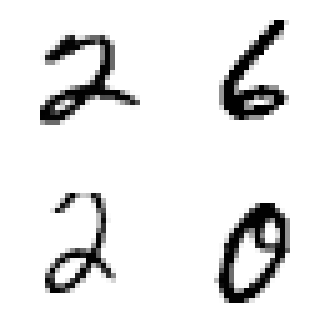

In [11]:
images, _ = next(train_iterator)
images = Variable(images)
real_labels = Variable(torch.ones(images.size(0), 1))

plt.figure(figsize=(4,4))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i,:].data.numpy().reshape(28, 28), cmap='Greys')
    plt.axis('off')

To use the generator, we create $p_z$ following a normal distribution.

In [12]:
# Sample from generator
noise = Variable(torch.randn(images.size(0), 100))
fake_images = generator(noise)
fake_labels = Variable(torch.zeros(images.size(0), 1))

Let's see what sort of images our random generator creates.

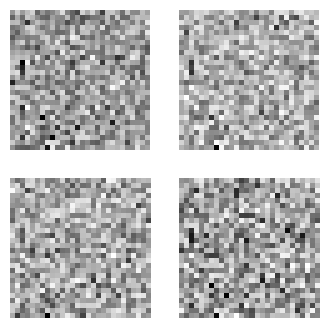

In [13]:
plt.figure(figsize=(4,4))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(fake_images[i,:].data.numpy().reshape(28, 28), cmap='Greys')
    plt.axis('off')

As could be expected, the random generator gives random noise images. We shouldn't expect much of a difference from the discriminator, given that its random.

In [14]:
d_real = discriminator(images)
d_fake = discriminator(fake_images)
d_real.detach().numpy()[:5], d_fake.detach().numpy()[:5]

(array([[0.4976788 ],
        [0.5069919 ],
        [0.506146  ],
        [0.4938547 ],
        [0.50291723]], dtype=float32),
 array([[0.49454367],
        [0.49419987],
        [0.49423203],
        [0.49434993],
        [0.49420565]], dtype=float32))

We'll now train the discriminator and generator.

## GAN Training

The loss function we'll use in training is the [Binary Cross-Entropy loss](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html#BCELoss). Looking at the PyTorch documentation, we can see that, by default, the `reduction` operator for $L$ is set to ``'mean'``, making the loss function:

$\ell(x, y) = L = \frac{1}{N}\sum\{l_1,\dots,l_N\}$

$l_n = - w_n \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]$

In [15]:
criterion = nn.BCELoss()
criterion(d_real, real_labels), criterion(d_fake, fake_labels)

(tensor(0.6937, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.6820, grad_fn=<BinaryCrossEntropyBackward0>))

This corresponds to the loss function defined above for the GAN:

$$\min_{G} \max_{D} V(D,G)  = \mathbb{E}_{x\sim p_{data}}[log D(x)] + \mathbb{E}_{z\sim p_{z}}[log(1 - D(G(z)))]$$

where for real data, $y_n$ is 1 and for generated data, $y_n$ is 0. We want the discriminator to predict 1 if the data is real and 0 if it is generated. This corresponds to the variables `real_labels` and `fake_labels`.

We'll also define the optimizers, simply using Adam for both the discriminiator and generator.

In [ ]:
d_optimizer = torch.optim.Adam(discriminator.parameters())
g_optimizer = torch.optim.Adam(generator.parameters())

<div class="alert alert-success">
    <h2>Exercise 2.</h2>

Write a training step for the discriminiator. The function definition is below. Fill in this missing components.
</div>

In [17]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels, criterion, d_optimizer):
    """
    Arguments:
        discriminator: discriminator model object
        images: a batch of data from the dataset
        real_labels: a vector of ones, size of images
        fake_images: a batch of images generated by the generator
        fake_labels: a vector of zeros, size of fake_images
        criterion: loss function (e.g., Binary Cross-Entropy)
        d_optimizer: optimizer for the discriminator

    Returns:
        d_loss: discriminator loss
        real_output: output of the discriminator on the real images
        fake_output: output of the discriminator on the fake images
    """
    # Reset gradients
    d_optimizer.zero_grad()

    # Compute the discriminator's predictions on real images
    real_output = discriminator(images)
    real_loss = criterion(real_output, real_labels)  # Loss for real images

    # Compute the discriminator's predictions on fake images
    fake_output = discriminator(fake_images)
    fake_loss = criterion(fake_output, fake_labels)  # Loss for fake images

    # Total discriminator loss (sum of real and fake losses)
    d_loss = real_loss + fake_loss

    # Backpropagation and optimization
    d_loss.backward()
    d_optimizer.step()

    return d_loss, real_output, fake_output


The second part of the min-max equation is the generator.

$$\min_{G} \max_{D} V(D,G)  = \mathbb{E}_{x\sim p_{data}}[log D(x)] + \mathbb{E}_{z\sim p_{z}}[log(1 - D(G(z)))]$$

Considering a static discriminator D, we have

$$\min_{G} V(D,G)  = \mathbb{E}_{x\sim p_{data}}[log D(x)] + \mathbb{E}_{z\sim p_{z}}[log(1 - D(G(z)))]$$

However, the generator doesn't influence $\mathbb{E}_{x\sim p_{data}}[log D(x)]$. The generator's loss is therefore only

$$\min_{G} V(D,G)  = \mathbb{E}_{z\sim p_{z}}[log(1 - D(G(z)))]$$

Note that other loss metrics have been proposed for GANs to encourage more stable training. For example, at the beginning of training, the discriminator's job is easy and so it might train much faster than the generator, halting the adversarial training. In order to increase early gradients, it is proposed to maximize $log(D(G(z)))$ instead of minimizing $log(1-D(G(z)))$ for the generator.

<div class="alert alert-success">
    <h2>Exercise 3.</h2>

Write a training step for the generator using the cross entropy loss. The function definition is below. Fill in this missing components.
</div>

In [18]:
def train_generator(generator, discriminator, fake_images, real_labels, criterion, g_optimizer):
    """
    Arguments:
        generator: generator model object
        discriminator: discriminator model object
        fake_images: images generated by the generator
        real_labels: a vector of ones, size of fake_images
        criterion: loss function (e.g., Binary Cross-Entropy)
        g_optimizer: optimizer for the generator

    Returns:
        g_loss: generator loss
        fake_output: output of the discriminator on fake images
    """
    # Reset gradients
    g_optimizer.zero_grad()

    # Generate new fake images
    fake_output = discriminator(fake_images)

    # Compute the generator loss (encouraging D to classify fake images as real)
    g_loss = criterion(fake_output, real_labels)

    # Backpropagation and optimization
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_output


# Model training

We'll now use our training functions in an iterative process over multiple epochs.

Due to the adversarial nature of GAN training, the different losses often oscillate over training instead of converging over time as we see in other deep learning training methods. As such, it is advised to frequently save results during training.

In [19]:
# Prepare folder to store results
if not os.path.exists('results'):
    os.makedirs('results')

# Prepare folder to store models
if not os.path.exists('models'):
    os.makedirs('models')

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
discriminator = Discriminator().to(device)
generator = Generator().to(device)
d_optimizer = torch.optim.Adam(discriminator.parameters())
g_optimizer = torch.optim.Adam(generator.parameters())

In [21]:
# Draw samples from the input distribution to inspect the generation on training
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100)).to(device)
# Set number of epochs and initialize figure counter
num_epochs = 20
num_batches = len(train_loader)
# Set counter
num_fig = 0

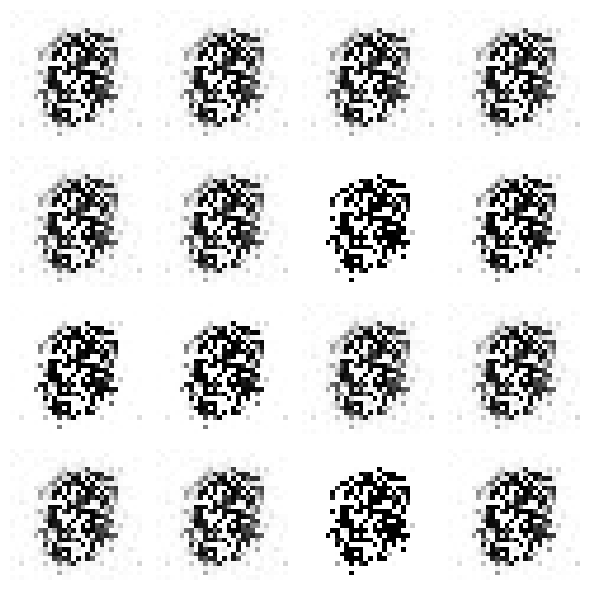

Epoch [1/20], Step[1/469], d_loss: 0.0000, g_loss: 83.7269, D(x): 1.00, D(G(z)): 0.00, time 11.94 min


<Figure size 640x480 with 0 Axes>

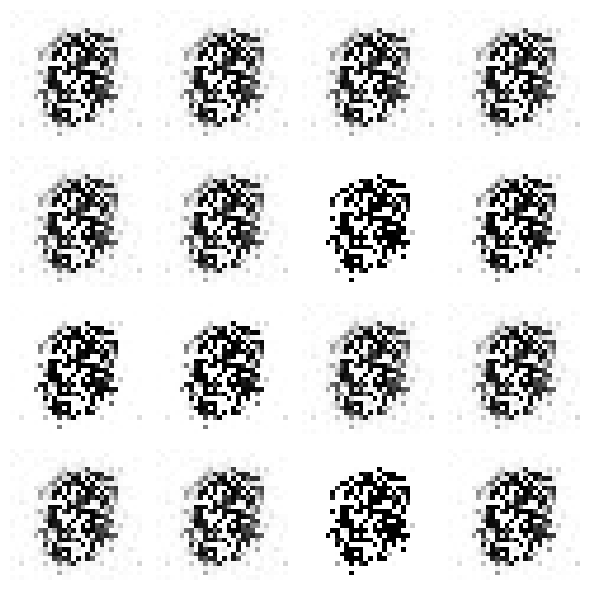

Epoch [2/20], Step[1/469], d_loss: 0.0000, g_loss: 84.4244, D(x): 1.00, D(G(z)): 0.00, time 12.21 min


<Figure size 640x480 with 0 Axes>

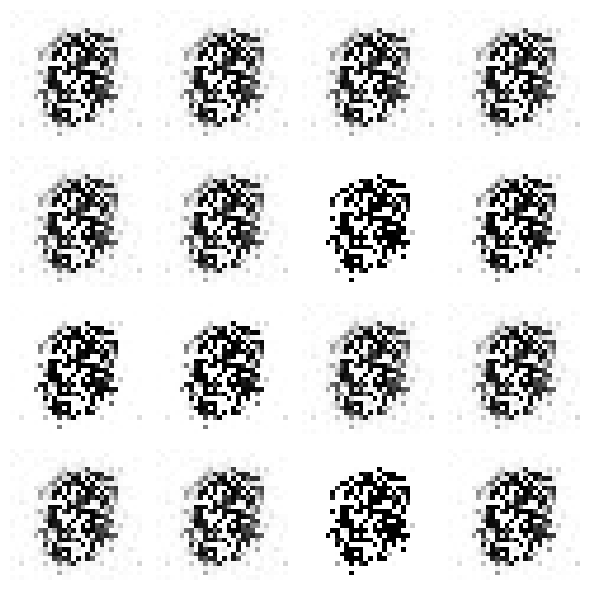

Epoch [3/20], Step[1/469], d_loss: 0.0000, g_loss: 85.1323, D(x): 1.00, D(G(z)): 0.00, time 12.50 min


<Figure size 640x480 with 0 Axes>

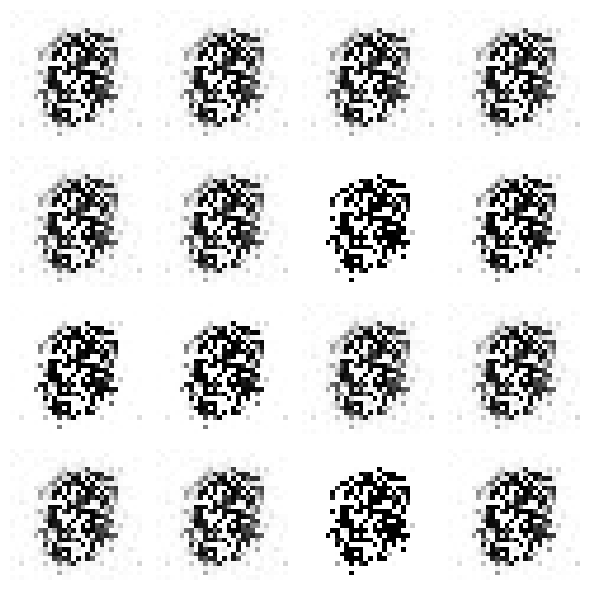

Epoch [4/20], Step[1/469], d_loss: 0.0000, g_loss: 83.9704, D(x): 1.00, D(G(z)): 0.00, time 12.78 min


<Figure size 640x480 with 0 Axes>

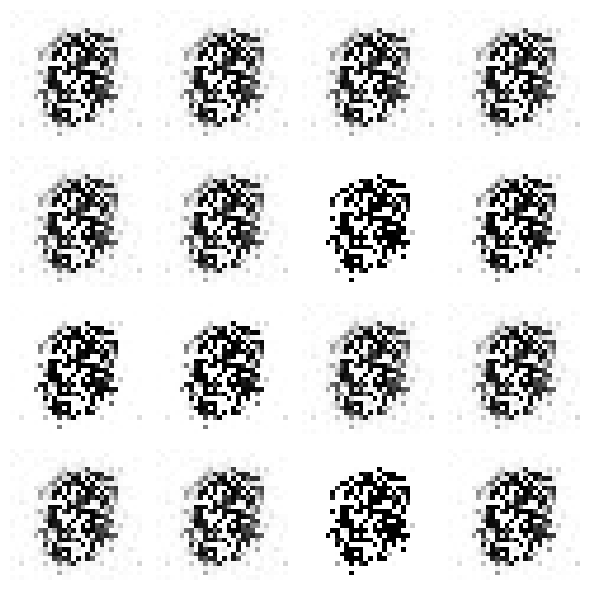

Epoch [5/20], Step[1/469], d_loss: 0.0000, g_loss: 85.0660, D(x): 1.00, D(G(z)): 0.00, time 13.05 min


<Figure size 640x480 with 0 Axes>

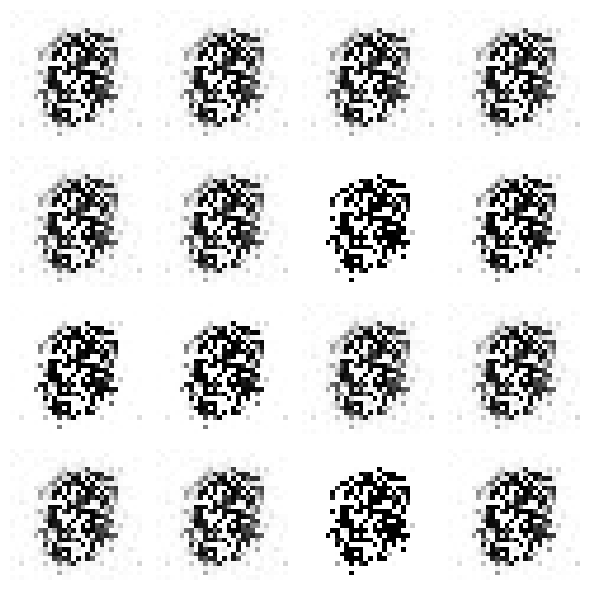

Epoch [6/20], Step[1/469], d_loss: 0.0000, g_loss: 83.8761, D(x): 1.00, D(G(z)): 0.00, time 13.36 min


<Figure size 640x480 with 0 Axes>

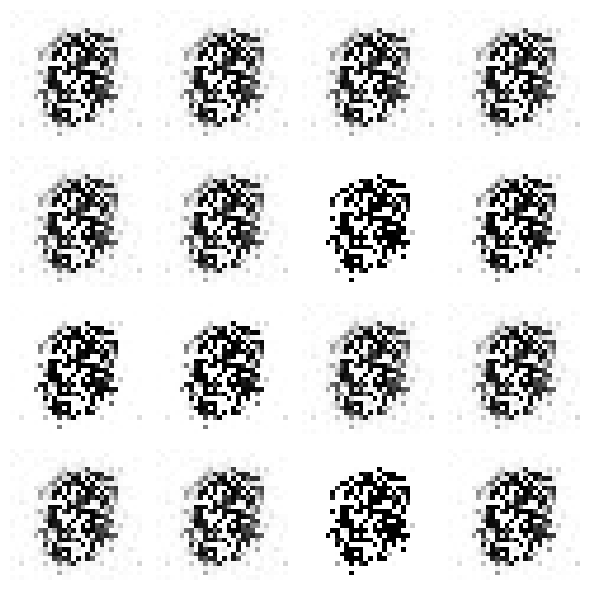

Epoch [7/20], Step[1/469], d_loss: 0.0000, g_loss: 83.7258, D(x): 1.00, D(G(z)): 0.00, time 13.63 min


<Figure size 640x480 with 0 Axes>

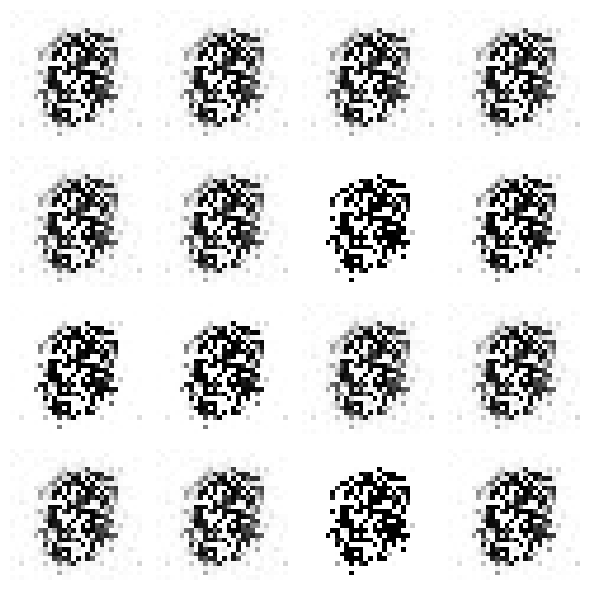

Epoch [8/20], Step[1/469], d_loss: 0.0000, g_loss: 83.7102, D(x): 1.00, D(G(z)): 0.00, time 13.91 min


<Figure size 640x480 with 0 Axes>

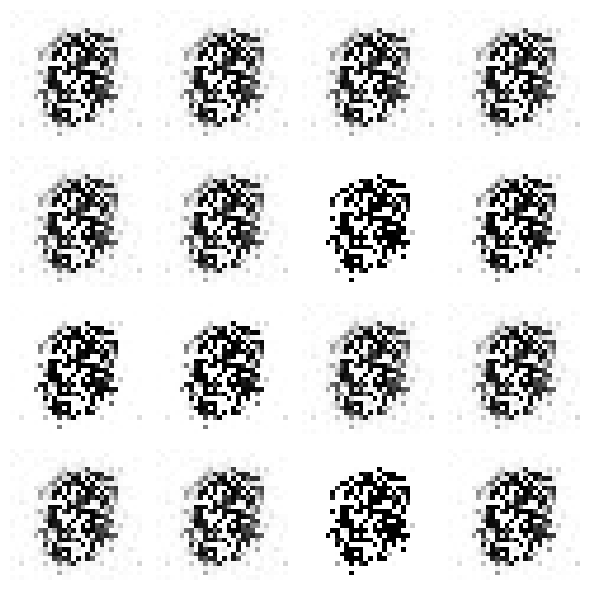

Epoch [9/20], Step[1/469], d_loss: 0.0000, g_loss: 86.4903, D(x): 1.00, D(G(z)): 0.00, time 14.19 min


<Figure size 640x480 with 0 Axes>

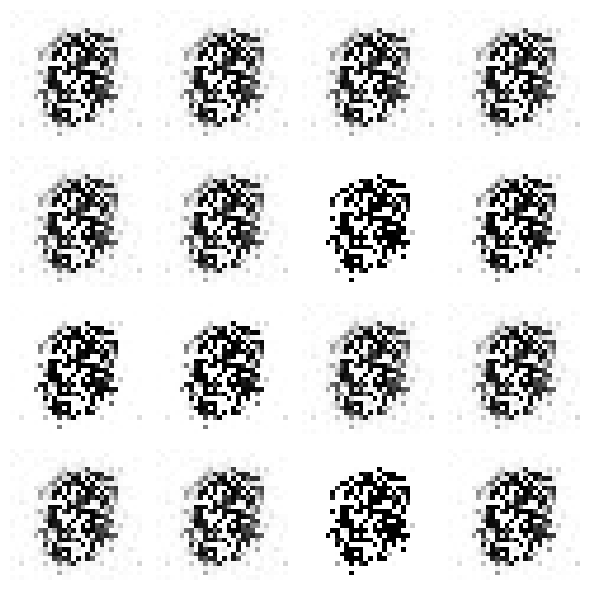

Epoch [10/20], Step[1/469], d_loss: 0.0000, g_loss: 84.2119, D(x): 1.00, D(G(z)): 0.00, time 14.47 min


<Figure size 640x480 with 0 Axes>

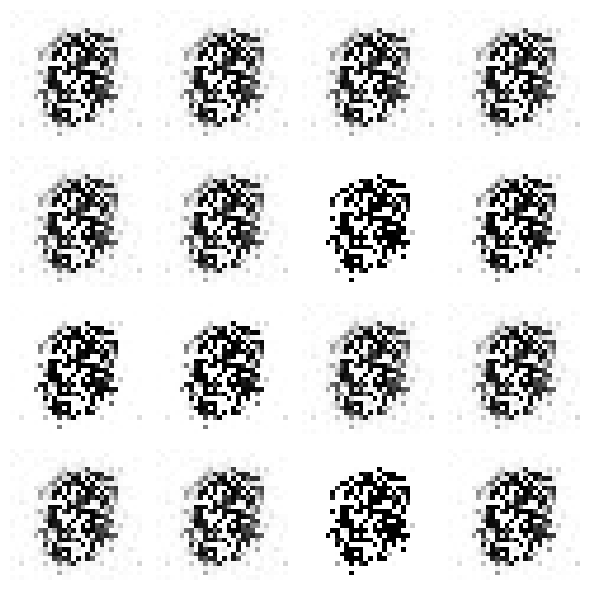

Epoch [11/20], Step[1/469], d_loss: 0.0000, g_loss: 83.7242, D(x): 1.00, D(G(z)): 0.00, time 14.75 min


<Figure size 640x480 with 0 Axes>

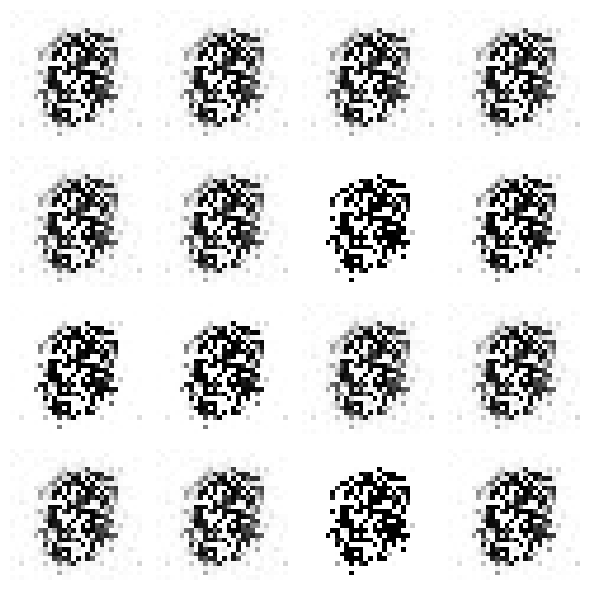

Epoch [12/20], Step[1/469], d_loss: 0.0000, g_loss: 83.7186, D(x): 1.00, D(G(z)): 0.00, time 15.03 min


<Figure size 640x480 with 0 Axes>

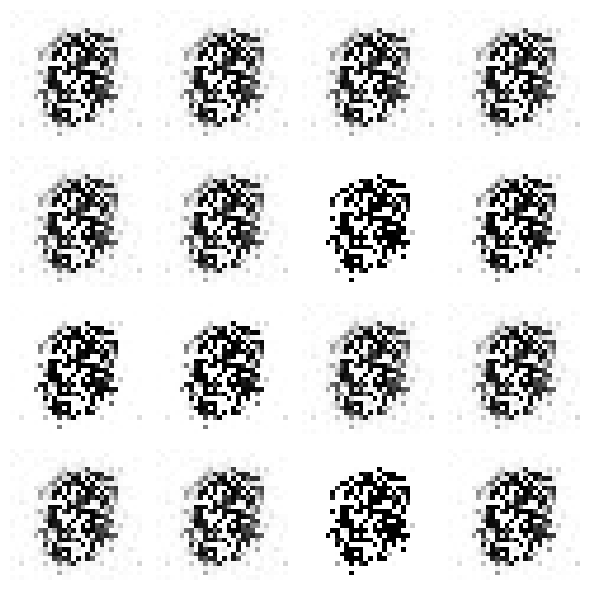

Epoch [13/20], Step[1/469], d_loss: 0.0000, g_loss: 83.6423, D(x): 1.00, D(G(z)): 0.00, time 15.30 min


<Figure size 640x480 with 0 Axes>

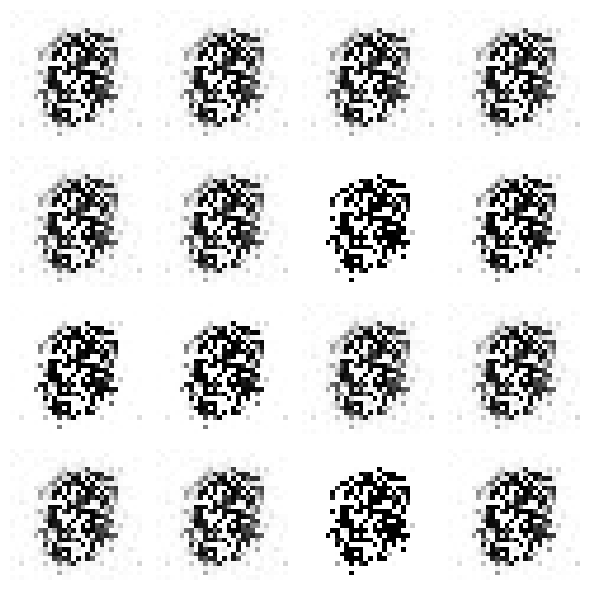

Epoch [14/20], Step[1/469], d_loss: 0.0000, g_loss: 86.1005, D(x): 1.00, D(G(z)): 0.00, time 15.58 min


<Figure size 640x480 with 0 Axes>

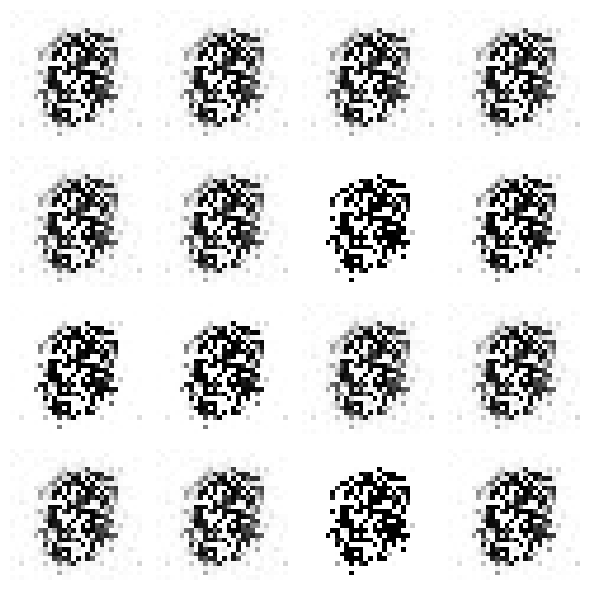

Epoch [15/20], Step[1/469], d_loss: 0.0000, g_loss: 82.6974, D(x): 1.00, D(G(z)): 0.00, time 15.86 min


<Figure size 640x480 with 0 Axes>

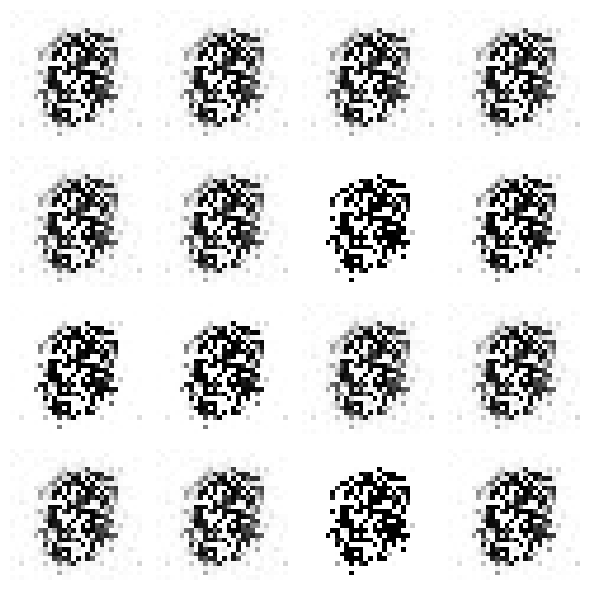

Epoch [16/20], Step[1/469], d_loss: 0.0000, g_loss: 84.2853, D(x): 1.00, D(G(z)): 0.00, time 16.13 min


<Figure size 640x480 with 0 Axes>

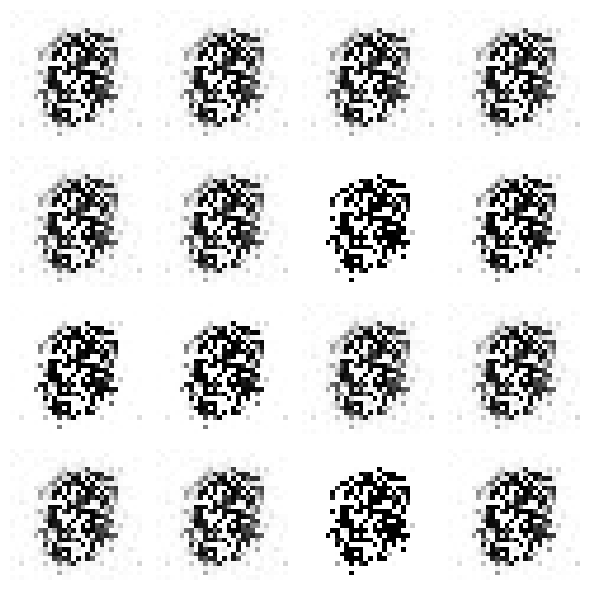

Epoch [17/20], Step[1/469], d_loss: 0.0000, g_loss: 83.0497, D(x): 1.00, D(G(z)): 0.00, time 16.41 min


<Figure size 640x480 with 0 Axes>

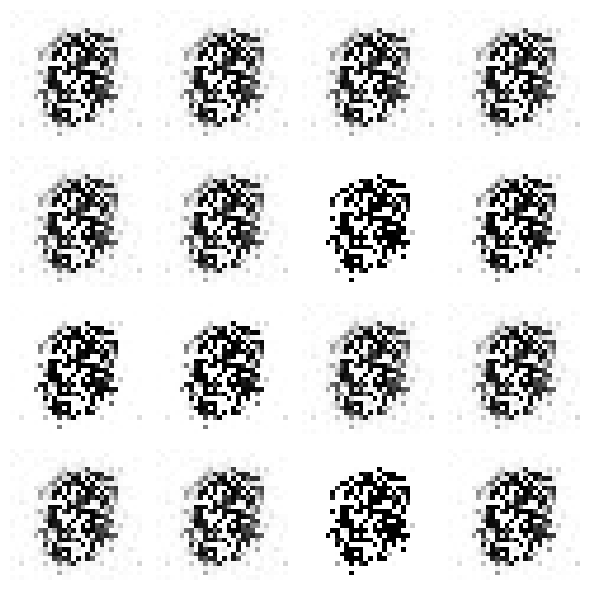

Epoch [18/20], Step[1/469], d_loss: 0.0000, g_loss: 84.4685, D(x): 1.00, D(G(z)): 0.00, time 16.68 min


<Figure size 640x480 with 0 Axes>

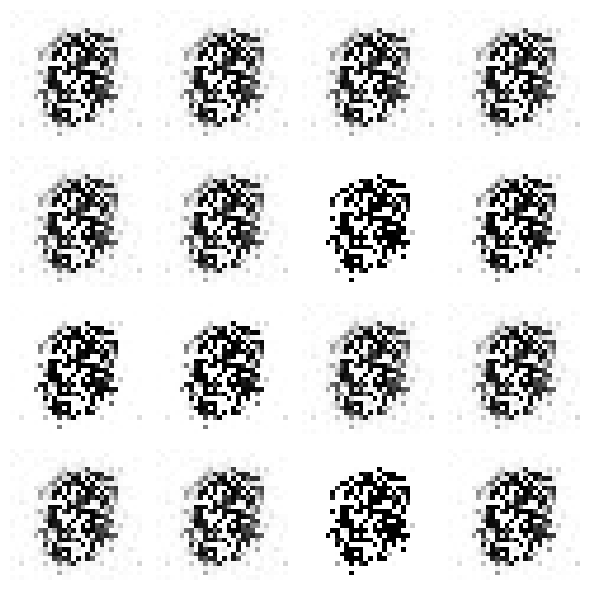

Epoch [19/20], Step[1/469], d_loss: 0.0000, g_loss: 83.5154, D(x): 1.00, D(G(z)): 0.00, time 16.95 min


<Figure size 640x480 with 0 Axes>

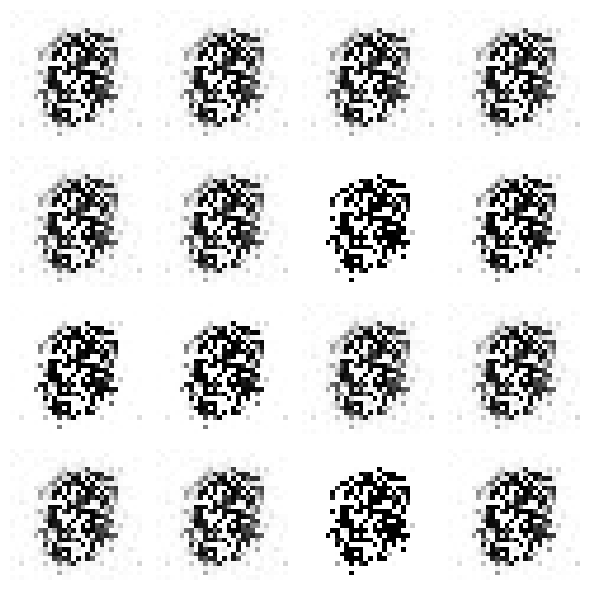

Epoch [20/20], Step[1/469], d_loss: 0.0000, g_loss: 82.7809, D(x): 1.00, D(G(z)): 0.00, time 17.24 min


<Figure size 640x480 with 0 Axes>

In [25]:
for epoch in range(num_epochs):
    for n, (images, _) in enumerate(train_loader):
        # Convert data to suitable format
        images = Variable(images).to(device)
        real_labels = Variable(torch.ones(images.size(0), 1)).to(device)

        # Sample from generator
        noise = Variable(torch.randn(images.size(0), 100)).to(device)
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0), 1)).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(
            discriminator, images, real_labels, fake_images, fake_labels, criterion, d_optimizer)

        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0), 100)).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss, _ = train_generator(generator, discriminator, fake_images, real_labels, criterion, g_optimizer)

        # At the start of each epoch generates pictures to monitor training
        if n == 0:
            # Generate pictures
            test_images = generator(test_noise)

            # Plot them
            fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
            for k in range(num_test_samples):
                i = k // size_figure_grid
                j = k % size_figure_grid
                ax[i, j].imshow(test_images[k, :].data.cpu().numpy().reshape(28, 28), cmap='Greys')
                ax[i, j].axis('off')  # Turn off axes for clarity

            # Ensure the figure is displayed
            plt.tight_layout()
            plt.show()

            # Save the picture
            plt.savefig(f'results/mnist-gan-{num_fig:03d}.png')
            num_fig += 1

            # Print log
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, '
                  'D(x): %.2f, D(G(z)): %.2f, time %.2f min'
                  % (epoch + 1, num_epochs, n + 1, num_batches,
                     d_loss.cpu().detach().numpy(),
                     g_loss.cpu().detach().numpy(),
                     real_score.cpu().detach().numpy().mean(),
                     fake_score.cpu().detach().numpy().mean(),
                     (time.time() - t0) / 60))
            g_losses[epoch] = g_loss.cpu().detach().numpy()
            d_losses[epoch] = d_loss.cpu().detach().numpy()

    # At the end of n epochs, save the models
    if epoch % 4 == 0:
        torch.save(generator.state_dict(),
                   os.path.join('models', 'generator.pkl'))
        torch.save(discriminator.state_dict(),
                   os.path.join('models', 'discriminator.pkl'))


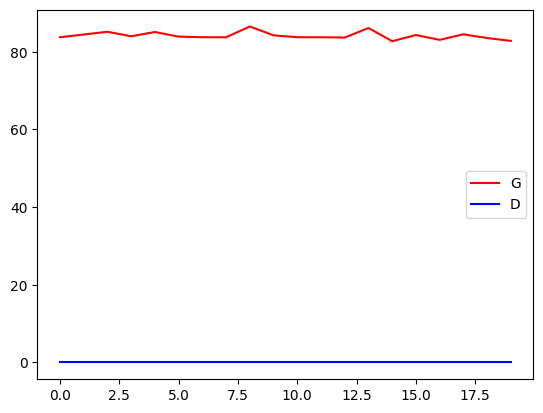

In [26]:
plt.plot(g_losses, c='r', label='G')
plt.plot(d_losses, c='b', label='D')
plt.legend();

## Exercise 4: Improving Training

GAN training is notoriously tricky. While many concrete improvements have been suggested over the years, small changes in hyperparameters and architecture choices are also impactful. An [empirical study](https://arxiv.org/pdf/1511.06434.pdf) offers some suggestions like:

+ Using LeakyReLU activation in the discriminator
+ Lowering the learning rate by a factor of 10, for example to 0.0002
+ Using a smaller momentum term $\beta_1$ of 0.5 in the Adam optimizer

Implement these changes and observe training. Does this improve the generated image quality? How can you measure an improvement in the generator network qualitatively?

## Exercise 5: Convolutional Networks

Because we used small MNIST images, it was feasible to flatten them and treat them as vectors. However, convolutional networks can better exploit spatial relationships in the images. Convert your generator and discriminator networks into convolutional networks. Does the generated image quality increase or decrease? How does the training dynamic change if one network is fully connected and the other convolutional?

## Exercise 6: Wasserstein GAN

Another loss function is using in the [Wasserstein GAN](https://arxiv.org/abs/1701.07875), which transforms the discriminator into a critic, outputting a real value which should be larger for real inputs than fake ones. While the Earth Mover's Distance, or Wasserstein-1 distance, is more effective as a comparison, simpler critic losses such as $D(x) - D(G(z))$ can be used for the discriminator, and $D(G(z))$ for the generator. Try implementing a simple critic loss for the GAN training and observing the new training. Does this formulation improve it?